In [7]:
import torch 
from torchvision import transforms as T 
from torch.utils.data import DataLoader, Dataset
from PIL import Image 
import numpy as np
from matplotlib import pyplot as plt 
from torchvision.utils import save_image, draw_bounding_boxes
import pandas as pd 
import os 
from torchvision.ops import masks_to_boxes
import cv2 
from ultralytics import YOLO
from tqdm import tqdm 
from torchvision.transforms import ToTensor, Resize

def cxcyxyxy_(bbox: list[float]) -> list[int]: 
    H, W = 456, 342 
    xc, yc, w, h = bbox 
    xc = int(xc * W)
    w = int(w * W)
    yc = int(yc * H)
    h = int(h * H) 
    xmin = xc - w//2 
    xmax = xc + w//2 
    ymin = yc - h//2 
    ymax = yc + h//2 
    return [xmin, ymin, xmax, ymax]

def get_label_(txt_path: str) ->list[float]: 
    with open(txt_path, 'r') as f: 
        bbox = f.read().split(' ')[1:]
        bbox = [float(cord) for cord in bbox] 
    bbox = cxcyxyxy_(bbox)
    return bbox

def detect_(model: torch.nn.Module, img: str or torch.Tensor) -> list[int]: 
    if isinstance(img, torch.Tensor): 
        img = Resize((640, 640))(img.unsqueeze(0)) 
    # if isinstance(img, str):
    #     img = Image.open(img) 
    #     img = ToTensor()(img).unsqueeze(0)
    #     res = torch.zeros((1, 3, 640, 640))
    #     res[:, :, :img.shape[2], :img.shape[3]] = img
    #     res = Resize((640, 640))(img)   
    bbox = model.predict(img, verbose=False)[0].boxes.xywhn.tolist()
    if not bbox: 
        return []
    bbox = cxcyxyxy_(bbox[0]) 
    return bbox


def compute_area_(xmin: int, ymin: int, xmax: int, ymax: int) -> int: 
    if ymin > ymax or xmin > xmax:
        return 0 
    return (ymax-ymin)*(xmax-xmin)

def compute_iou_(gt: list[int], preds: list[int]) -> float: 
    xmin = max(gt[0], preds[0]) 
    ymin = max(gt[1], preds[1]) 
    xmax = min(gt[2], preds[2]) 
    ymax = min(gt[3], preds[3]) 
    if xmin >= xmax or ymin >= ymax: 
        return 0.0 
    intsn = compute_area_(xmin, ymin, xmax, ymax)
    gt = compute_area_(*gt) 
    preds = compute_area_(*preds) 
    iou = intsn/(gt+preds-intsn)
    return iou


def compute_AP_(model_path: str,dir_path:str, threshold: float) -> float: 
    model = YOLO(model_path)
    img_paths = [os.path.join(dir_path, 'images', img_path) for img_path in os.listdir(os.path.join(dir_path, 'images'))]
    total = len(img_paths)
    num_preds = 0
    with tqdm(enumerate(img_paths), total=len(img_paths)) as pbar: 
        for i, img_path in pbar:
            idx = img_path.split('/')[-1].split('.')[-2]
            label_path = os.path.join(dir_path, 'labels', str(idx) + '.txt')
            gt = get_label_(label_path)
            pred = detect_(model, img_path)
            if not pred:
                continue 
            iou = compute_iou_(gt, pred) 
            if iou > threshold: 
                num_preds += 1 
            pbar.set_postfix({'AP @ {}'.format(threshold): num_preds/(1+i)})
            
    return num_preds/total

if __name__ == '__main__':
    thresholds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    # thresholds = list() 
    yolov5_ = dict()
    yolov8_ = dict()
    yolov10_ = dict()
    for threshold in thresholds:
        yolov5_[threshold] = compute_AP_('../../yolo/runs/detect/yolov5l6u/weights/best.pt', '../../yolo/yolo-data/val', threshold)
        yolov8_[threshold] = compute_AP_('../../yolo/runs/detect/yolov8n/weights/best.pt', '../../yolo/yolo-data/val', threshold)
        yolov10_[threshold] = compute_AP_('../../yolo/runs/detect/yolov10n/weights/best.pt', '../../yolo/yolo-data/val', threshold)


100%|██████████| 3008/3008 [00:28<00:00, 103.88it/s, AP @ 0.9=0.132]


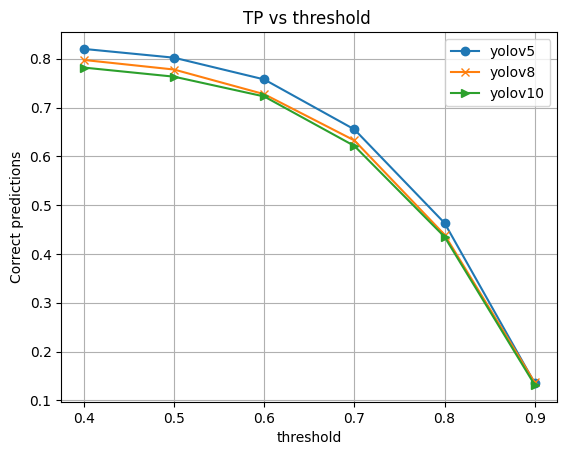

In [10]:
plt.plot(yolov5_.values(), label='yolov5', marker='o') 
plt.plot(yolov8_.values(), label='yolov8', marker='x') 
plt.plot(yolov10_.values(), label='yolov10', marker='>') 
plt.title('TP vs threshold ')
plt.xticks(range(len(thresholds)), thresholds)
plt.legend()
plt.grid()
plt.xlabel('threshold') 
plt.ylabel('Correct predictions')
plt.savefig('IOU_.png') 

Computing AP @ 0.9: 100%|██████████| 188/188 [00:19<00:00,  9.75it/s, AP @ 0.9=0.527, Instsn @ 0.9=0.624]


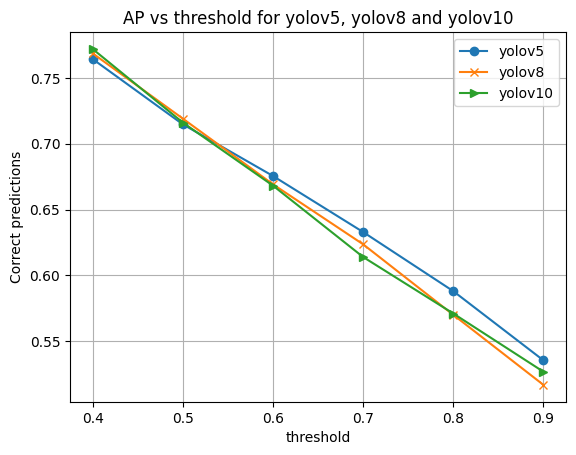

In [4]:
import torch 
from torch import Tensor
from PIL import Image 
import numpy as np
from matplotlib import pyplot as plt 
from torchvision.utils import save_image, draw_bounding_boxes
import pandas as pd 
import os 
from torchvision.ops import masks_to_boxes
import cv2 
from ultralytics import YOLO
from tqdm import tqdm 
from torchvision.transforms import ToTensor, Resize


class YoloDataset(Dataset): 
    def __init__(self, img_folder: str) -> None: 
        self.img_folder = img_folder
        img_dir = os.path.join(img_folder, 'images')
        labels_dir = os.path.join(img_folder, 'labels')
        self.imgs_paths = sorted([os.path.join(img_folder, 'images', img) for img in os.listdir(img_dir)])
        self.labels_paths = sorted([os.path.join(img_folder, 'labels', label) for label in os.listdir(labels_dir)])
        self.transforms = T.Compose([T.ToTensor(), 
                                        T.Resize((640, 640))])
        
    def __len__(self) -> int:
        return len(self.imgs_paths)
    
    def __getitem__(self, idx: int) -> tuple[Tensor] : 
        img_path = self.imgs_paths[idx]
        img = Image.open(img_path)
        img = self.transforms(img)
        labels = get_label(self.labels_paths[idx])
        return img_path, labels 




def cxcyxyxy(bbox: Tensor) -> Tensor:
    H, W = 456, 342 
    img_size = torch.tensor([[W, H]], device=bbox.device)
    centre = bbox[:, :2] * img_size
    scale = bbox[:, 2:] * img_size
    left = centre - scale/2
    right = centre + scale/2
    bbox = torch.cat([left, right], dim=1).to(device=bbox.device)
    return bbox.to(torch.uint8) 

def get_label(txt_path: str) -> Tensor:  
    with open(txt_path, 'r') as f: 
        bbox = f.read().split(' ')[1:]
        bbox = torch.tensor([[float(cord) for cord in bbox]]) 
        bbox = cxcyxyxy(bbox)
    return bbox.squeeze(0)

def detect(model: torch.nn.Module, img:Tensor, conf_threshold: float=0.5) -> list[int]: 
    bboxes = model.predict(img, verbose=False)
    bboxes = torch.cat([bbox.boxes.xywhn if bbox.boxes.xywhn.shape == (1, 4) else torch.ones(1, 4,device=bbox.boxes.xywhn.device) for bbox in bboxes], dim=0) 
    bboxes = cxcyxyxy(bboxes)
    pad = 0
    bboxes += torch.tensor([[-pad, -pad, pad, pad]], device=bboxes.device)
    return bboxes

def compute_area(bboxes: Tensor) -> Tensor: 
    area = (bboxes[:, 2] - bboxes[:, 0]) * (bboxes[:, 3] - bboxes[:, 1])
    area = torch.where(area > 0, area, torch.zeros_like(area))
    return area

def compute_iou(preds: Tensor, gt: Tensor) -> Tensor: 
    xmin = torch.max(gt[:, 0], preds[:, 0]) 
    ymin = torch.max(gt[:, 1], preds[:, 1]) 
    xmax = torch.min(gt[:, 2], preds[:, 2]) 
    ymax = torch.min(gt[:, 3], preds[:, 3]) 
    iou_boxes = torch.stack([xmin, ymin, xmax, ymax], dim=1)
    intsn = compute_area(iou_boxes)
    gt = compute_area(gt) 
    preds = compute_area(preds) 
    iou = intsn/(gt+preds-intsn)
    return iou

def compute_intsn(preds: Tensor, gt: Tensor) -> Tensor: 
    # pad = 20 
    # preds = preds + torch.tensor([[-pad, -pad, pad, pad]], device=gt.device)
    xmin = torch.max(gt[:, 0], preds[:, 0]) 
    ymin = torch.max(gt[:, 1], preds[:, 1]) 
    xmax = torch.min(gt[:, 2], preds[:, 2]) 
    ymax = torch.min(gt[:, 3], preds[:, 3]) 
    iou_boxes = torch.stack([xmin, ymin, xmax, ymax], dim=1)
    intsn = compute_area(iou_boxes)
    gt_area = compute_area(gt)
    return intsn/gt_area

 
def compute_AP(model_path: str,dir_path:str, iou_threshold: float, conf_threshold: float=0.5, batch_size: int=16) -> float: 
    model = YOLO(model_path)
    num_preds = 0
    num_instsn = 0
    dataloader = DataLoader(YoloDataset(dir_path), batch_size=batch_size, shuffle=False, drop_last=True)
    total = len(dataloader) * batch_size
    with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar: 
        pbar.set_description('Computing AP @ {}'.format(iou_threshold))
        for i, (img, gt) in pbar:
            # img = img.to('cuda')
            pred = detect(model, img, conf_threshold)
            iou = compute_iou(gt.to(pred.device), pred) 
            intsn = compute_intsn(gt.to(pred.device), pred)
            num_preds += torch.sum(iou > iou_threshold).item()
            num_instsn += torch.sum(intsn > iou_threshold).item()
            pbar.set_postfix({'AP @ {}'.format(threshold): num_preds/(batch_size*(1+i)),
                                'Instsn @ {}'.format(threshold): num_instsn/(batch_size*(1+i))})
    return num_preds/total

if __name__ == '__main__':
    thresholds = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    # thresholds = list() 
    yolov5 = dict()
    yolov8 = dict()
    yolov10 = dict()
    batch_size = 64*4
    for threshold in thresholds:
        yolov5[threshold] = compute_AP('../../yolo/runs/detect/yolov5l6u/weights/best.pt', '../../yolo/yolo-data/val', threshold)
        yolov8[threshold] = compute_AP('../../yolo/runs/detect/yolov8n/weights/best.pt', '../../yolo/yolo-data/val', threshold)
        yolov10[threshold] = compute_AP('../../yolo/runs/detect/yolov10n/weights/best.pt', '../../yolo/yolo-data/val', threshold)


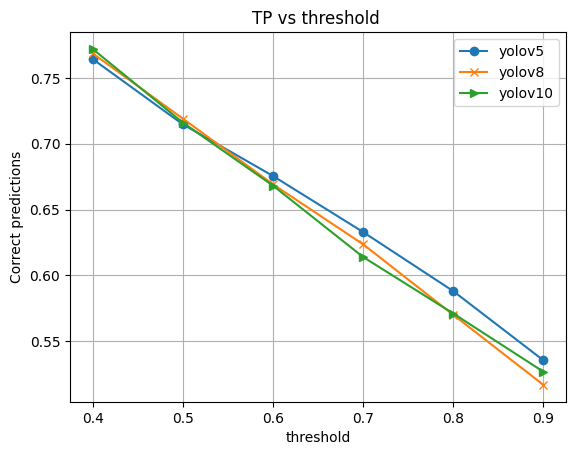

<Figure size 640x480 with 0 Axes>

In [6]:
plt.plot(yolov5.values(), label='yolov5', marker='o') 
plt.plot(yolov8.values(), label='yolov8', marker='x') 
plt.plot(yolov10.values(), label='yolov10', marker='>') 
plt.title('TP vs threshold ')
plt.xticks(range(len(thresholds)), thresholds)
plt.legend()
plt.grid()
plt.xlabel('threshold') 
plt.ylabel('Correct predictions')
plt.show()
plt.savefig('IOU.png')


In [ ]:
model = YOLO('runs/detect/train6/weights/best.pt', verbose=False)
idx = 1
img_path = '/home/shivac/qml-mn/yolo/yolo-data/train/images/{}.png'.format(str(idx))
mask_path = '/home/shivac/qml-mn/yolo/yolo-data/train/masks/{}.png'.format(str(idx))
label_path = '/home/shivac/qml-mn/yolo/yolo-data/train/labels/{}.txt'.format(str(idx))
img = Image.open(img_path)
mask = Image.open(mask_path)
img = ToTensor()(img).unsqueeze(0)
img = Resize((640, 640))(img)
preds_ = detect_(model, img.squeeze(0))  
preds = detect(model, img)  
label_ = get_label_(label_path)
label = get_label(label_path) 
iou_ = compute_iou_(label_, preds_)
iou = compute_iou(label.unsqueeze(0).to(preds.device), preds)

UnboundLocalError: cannot access local variable 'res' where it is not associated with a value

In [ ]:
print(f'IOU_ = {iou_}, IOU = {iou}')
print(f'Preds_ = {preds_}, Preds = {preds}')
print(f'Label_ = {label_}, Label = {label}')


IOU_ = 0.9353846153846154, IOU = tensor([0.8096], device='cuda:0')
Preds_ = [212, 46, 290, 96], Preds = tensor([[209,  43, 292,  98]], device='cuda:0')
Label_ = [214, 47, 290, 95], Label = tensor([214,  47, 291,  95])


In [ ]:
!echo '
def cxcyxyxy(bbox: Tensor) -> Tensor:
    H, W = 456, 342 
    img_size = torch.tensor([[W, H]], device=bbox.device)
    centre = bbox[:, :2] * img_size
    scale = bbox[:, 2:] * img_size
    left = centre - scale/2
    right = centre + scale/2
    bbox = torch.cat([left, right], dim=1).to(device=bbox.device)
    return bbox.to(torch.uint8) 

'

SyntaxError: unterminated string literal (detected at line 12) (2321357706.py, line 12)

In [ ]:
from ultralytics import YOLO 
idx = 1000
img_path = '/home/shivac/qml-mn/yolo/yolo-data/val/images/{}.png'.format(str(idx))
model = YOLO('runs/detect/train5/weights/best.pt', verbose=False)
box = model(img_path)[0].boxes.xywhn 


image 1/1 /home/shivac/qml-mn/yolo/yolo-data/val/images/1000.png: 512x384 1 Median Nerve, 22.5ms
Speed: 1.5ms preprocess, 22.5ms inference, 5.4ms postprocess per image at shape (1, 3, 512, 384)


In [ ]:
import torch 
empty = torch.zeros((1, 4), device=box.device)
boxes = torch.cat([box, empty, empty, empty , empty], dim=0)
boxes, boxes.shape


(tensor([[0.6321, 0.4392, 0.1619, 0.1034],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000]], device='cuda:0'),
 torch.Size([5, 4]))

In [ ]:
len(torch.where(boxes.sum(dim=1) == 0)[0]), torch.where(boxes.sum(dim=1) == 0)

(4, (tensor([1, 2, 3, 4], device='cuda:0'),))

In [ ]:
idxs = torch.where(boxes.sum(dim=1) == 0)[0].cuda()
img = torch.randn(5, 3, 3).cuda()
img = img[idxs] 
print(f'{img.shape = }')


# dataloader = DataLoader(YoloDataset('yolo-data/train'), batch_size=16, shuffle=False)
# img, labels = next(iter(dataloader))
# img.shape, labels.shape 

img.shape = torch.Size([4, 3, 3])


In [ ]:
pred = set(idxs.tolist())  
pred.add(1)
pred.add(2)
pred.add(3)
print(pred)

{1, 2, 3, 4}


In [ ]:
yolov5 = dict()
yolov8 = dict()
thresholds = [0.5, 0.6]
for threshold in thresholds:
    break
    yolov5[threshold] = compute_AP('runs/detect/train6/weights/best.pt', 'yolo-data/val', threshold)
    yolov8[threshold] = compute_AP('runs/detect/train5/weights/best.pt', 'yolo-data/val', threshold)

# plt.plot(yolov5.values(), label='yolov5', marker='o') 
# plt.plot(yolov8.values(), label='yolov8', marker='x') 
# plt.title('AP vs threshold for yolov5 and yolov8')
# plt.xticks(range(6), thresholds)
# plt.legend()
# plt.grid()
# plt.xlabel('threshold') 
# plt.ylabel('Correct predictions')
# # plt.savefig('AP.png')

In [ ]:
preds = preds[0].tolist()
label = label[0].tolist()
cv_img = cv2.imread(img_path) 
cv2.rectangle(cv_img, (label[0], label[1]), (label[2], label[3]), (0, 255, 0), 2)
cv2.rectangle(cv_img, (preds[0], preds[1]), (preds[2], preds[3]), (0, 0, 255), 2)
plt.imshow(cv_img)

TypeError: 'int' object is not subscriptable

In [ ]:
import torch 
from PIL import Image 

idx = 10
img_path = '/home/shivac/qml-mn/yolo/yolo-data/train/images/{}.png'.format(str(idx))
mask_path = '/home/shivac/qml-mn/yolo/yolo-data/train/masks/{}.png'.format(str(idx))
labels = get_label('/home/shivac/qml-mn/yolo/yolo-data/train/labels/10.txt')
img = Image.open(img_path)
mask = Image.open(mask_path)
img = ToTensor()(img)
img = Resize((640, 640))(img).unsqueeze(0)
img = torch.cat([img, img], dim=0)
model = YOLO('runs/detect/train6/weights/best.pt')
preds = model(img, verbose=False)
gt = get_label('/home/shivac/qml-mn/yolo/yolo-data/train/labels/10.txt') 
gt = torch.cat([gt, gt], dim=0)
preds = detect(model, img)

compute_iou(preds, gt.to(device=preds.device))


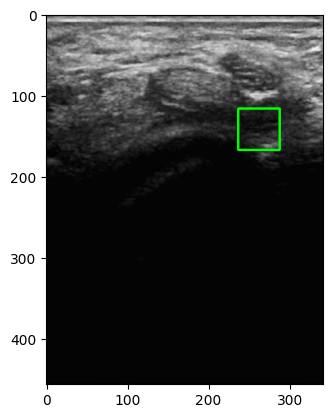

In [ ]:
import cv2 
import matplotlib.pyplot as plt 

cv_img = cv2.imread(img_path) 
cv_labels = get_label('/home/shivac/qml-mn/yolo/yolo-data/train/labels/10.txt').long().tolist()
cv2.rectangle(cv_img, cv_labels[:2], cv_labels[2:], (0, 255, 0), 2)
plt.imshow(cv_img)

In [ ]:
img = torch.randn(1, 3, 456, 342) 
res = torch.zeros(1, 3, 640, 640)
res[:, :, :456, :342] = img
res.shape

torch.Size([1, 3, 640, 640])

In [ ]:
from ultralytics import YOLO
from torchvision.transforms import ToTensor, Resize
from PIL import Image
model = YOLO('runs/detect/train6/weights/best.pt')
img_path = '/home/shivac/qml-mn/yolo/yolo-data/train/masks/10.png'
img = Image.open(img_path)
img = ToTensor()(img).unsqueeze(0)
img = Resize((640, 640))(img)
preds = model(img_path, verbose=False)
preds[0].boxes.xywhn.tolist()

[]

In [ ]:
img_path = [img_path, img_path]
model(img_path, verbose=False)

[ultralytics.engine.results.Results object with attributes:
 
 boxes: ultralytics.engine.results.Boxes object
 keypoints: None
 masks: None
 names: {0: 'Median Nerve'}
 obb: None
 orig_img: array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [25

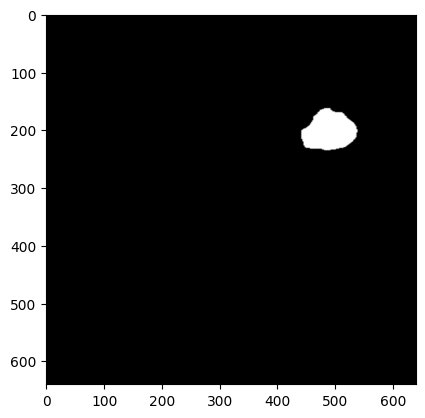

In [ ]:
import matplotlib.pyplot as plt 
plt.imshow(img.squeeze(0).permute(1, 2, 0), cmap='gray')